In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# View all of the classes that automap found
for table_name in Base.classes.keys():
    print(table_name)

measurement
station


In [28]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [30]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the data set is {recent_date}.")

The most recent date in the data set is 2017-08-23.


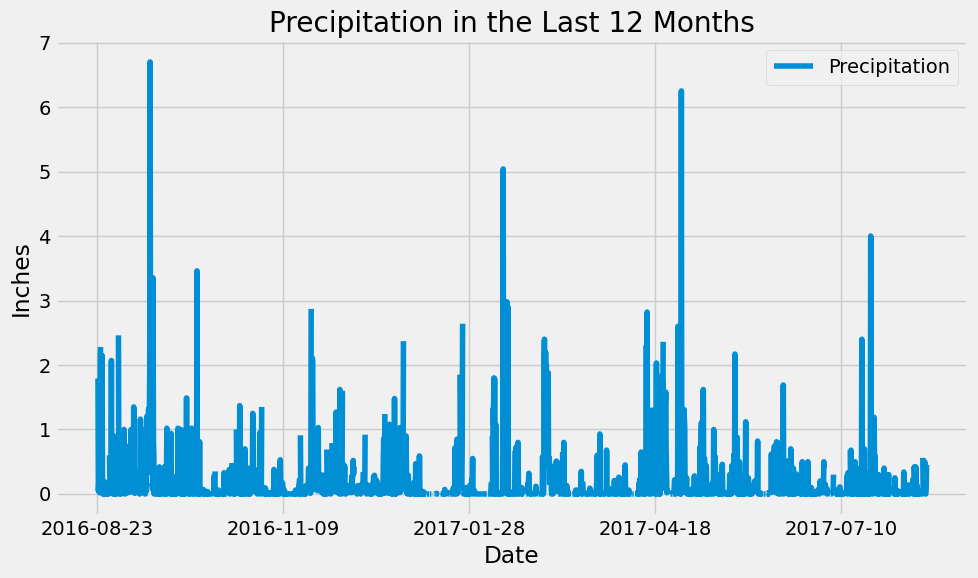

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = (dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(10, 6))
plt.title("Precipitation in the Last 12 Months")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Measurement.station))).scalar()
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [49]:
# Design a query to find the most active stations
# List the stations and their counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

# Which station ID has the greatest number of observations?

Answer: Station USC00519281 WAIHEE 837.5, HI US

In [52]:
# Using the most active station ID from the previous query, calculate the lowest, highest, and average temperature.
low_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").\
        group_by(Measurement.station).all()

high_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").\
        group_by(Measurement.station).all()

avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
        filter(Measurement.station == "USC00519281").\
        group_by(Measurement.station).all()

print(f"Lowest temperature at Station {low_temp[0][1]} fahrenheit")
print(f"Highest temperature at Station {high_temp[0][1]} fahrenheit")
print(f"Average temperature at Station {avg_temp[0][1]} fahrenheit")

Lowest temperature at Station 54.0 fahrenheit
Highest temperature at Station 85.0 fahrenheit
Average temperature at Station 71.66378066378067 fahrenheit


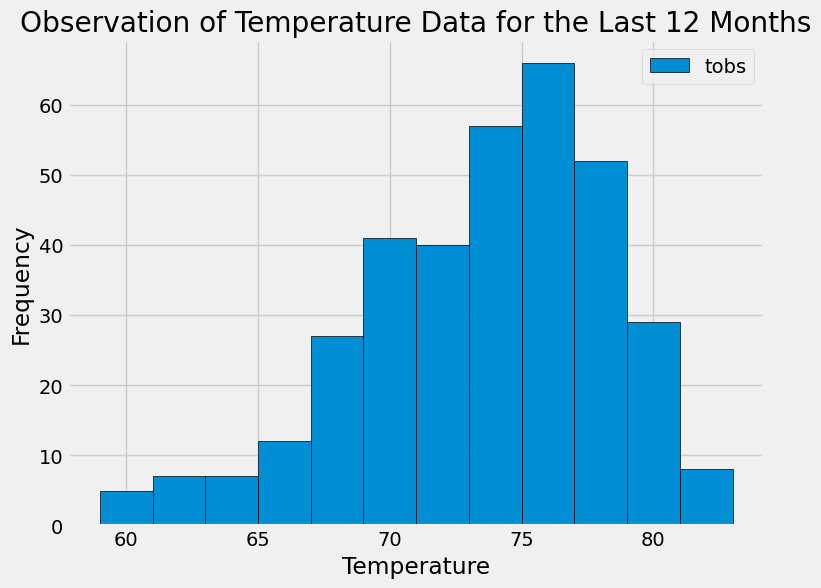

In [53]:
# Design a query to get the previous 12 months of temperature observation (TOBS) data

#Filter by the station that has the greatest number of observations
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    first()[0]

# Calculate the date one year ago from the last data point in the database
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    first()[0]
year_ago_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
active_station_df = pd.DataFrame(results, columns=['TOBS'])

# Plot the results as a histogram
active_station_df.plot.hist(bins=12, figsize=(8,6), edgecolor='black')
plt.title("Observation of Temperature Data for the Last 12 Months")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()


# Close Session

In [55]:
# Close Session
session.close()